In [2]:
import sys
import os
import datetime

%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats

from datetime import datetime
from collections import Counter
import csv

# Calculate ECS in CMIP6 models
## Goal: Use Gregory regression to calculate ECS $\Delta T$ [Gregory et al 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018747) 

### For each model, average over all members of abrupt-4xCO2 simulations available 

### CMIP6 data repo: NCAR CGD local sync of the ETH repository (including utilities)

## Potentially useful utilities to get the pathnames 

### imitate cell area from cosine latitude weighting for most models

### For some model, experiment, and variables, get all available variants (ensemble members) and filenames. Define a class to put them in. 

In [3]:
def getOneModelExperimentVar(model,experiment,var):
    basedir = '/project/cmip6/'
    # new: basedir/experiment/Amon/"+variable+" / model / variant / gridlabel /
    # old: basedir/institution/model/experiment/variant/Amon/"+variable / gridlabel / version {latest/vDATE} 
    thisModelExpVar = []
    models = os.listdir(basedir+experiment+"/Amon/"+var)
    hasmodel = any(elem == model for elem in models)
    if hasmodel:
        # get ensemble members with data and also their end paths
        variants,gridlabels = getvariants(basedir+experiment+"/Amon/"+var+"/"+model+"/")
        if len(variants)>0:
            thisModelExpVar = ModelExpVar(model,experiment,var,basedir+experiment+"/Amon/"+var+"/"+model,variants,gridlabels)
    else:
        print(experiment+" doesn't have "+model)
    return thisModelExpVar

In [4]:
def getvariants(pathtoexp):
    variants = []
    gridlabels = [] 
    for variant in sorted(os.listdir(pathtoexp)):
        thispath = pathtoexp+variant
        #print(thispath)
        thesegridlabels=os.listdir(thispath)
        #print(gridlabels)
        if len(thesegridlabels)==1:
            gridlabel=thesegridlabels[0]
            files = os.listdir(thispath+"/"+gridlabel)
            #print(files)
            ncfiles = [item for item in files if item.endswith('.nc')]
            if len(ncfiles)>0:
                variants.append(variant)
                gridlabels.append(gridlabel)
        else:
            print(len(thesegridlabels)+"grid labels - skipping")
    return variants,gridlabels

In [5]:
class ModelExpVar:
  def __init__(self, model, experiment, variable,startpath,variants,gridlabels):
    self.model = model
    self.experiment = experiment
    self.variable = variable
    # The rest are derived
    ## basedir/experiment/Amon/"+variable+" / model / variant / gridlabel /
    paths = []
    files = []
    for i in range(len(variants)):
        #print(variants[i])
        thepath = startpath+"/"+variants[i]+"/"+gridlabels[i]
        ensfiles = os.listdir(thepath)
        thisensfiles = []
        for file in ensfiles:
            if file.endswith(".nc"):
                # deals with duplicate files in GISS-E2-1-G
                if (model+"_"+experiment in file):  
                    thisensfiles.append(thepath+"/"+file)
        startdates=[]
        lengthinfo = {}
        fileinfo = {}
        for file in thisensfiles:
            dates=file.split("_")[-1].split(".")[0].split("-")
            dt = datetime.strptime(dates[1], '%Y%m').year - datetime.strptime(dates[0], '%Y%m').year
            if dates[0] in startdates:
                # we have a duplicate
                ## this should only happen for E3SM piControl
                duplicate=True
                onefile=[]
                if model=="E3SM-1-0":
                    print('duplicate fix designed for E3SM-1-0 piControl')
                    print('current model and experiment: '+model+', '+experiment)
                    ## deal with duplicate files in E3SM piControl
                    ## assume that if there are duplicates, they are of the form that all files are concatenated into one (eg e3sm)
                    ## check for duplicate start dates. if there's more than one, take the longer one and delete all the others.
                    if dt>lengthinfo[dates[0]]:
                        onefile.append(file)
                    else:
                        onefile.append(fileinfo[dates[0]])
                    thisensfiles=onefile
                elif model=="GFDL-CM4":
                    onefile
                    print('duplicate fix designed for GFDL-CM4 abrupt4xCO2')
                    print('current model and experiment: '+model+', '+experiment)
                    ## deal with duplicate files in GFDL-CM4 abrupt4xCO2
                    ## keep the longer of the two files, get rid of the other
                    ## don't get rid of the other files
                    if dt>lengthinfo[dates[0]]:
                        thisensfiles.remove(fileinfo[dates[0]])
                    else:
                        thisensfiles.remove(file)
                else:
                    print('duplicate file start date, not fixed ')
                    print('current model and experiment: '+model+', '+experiment)        
                    sys.exit(1)
                break
            startdates.append(dates[0])
            lengthinfo[dates[0]]=dt
            fileinfo[dates[0]]=file
        files.append(sorted(thisensfiles))
    self.variants = dict(zip(variants, files))


### For experiment and variable, get all models with data (and their variants [ensemble members] and filenames). 

In [6]:
def getModelsForExperimentVar(experiment,var):
    basedir = '/project/cmip6/'
    ## basedir/experiment/Amon/"+variable+" / model / variant / gridlabel /
    evd_ofmodels = {}
    #models = os.listdir(basedir+experiment+"/Amon/"+var)
    #print(models)
    for model in os.listdir(basedir+experiment+"/Amon/"+var):
        #print(model)
        variants,gridlabels = getvariants(basedir+experiment+"/Amon/"+var+"/"+model+"/")
        if len(variants)>0:
            #print(model)
            evd_ofmodels[model] = ModelExpVar(model,experiment,var,basedir+experiment+"/Amon/"+var+"/"+model,variants,gridlabels)
    return evd_ofmodels

In [7]:
model = "CESM2"
cesm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
imem = list(cesm4x.variants)[0]
print(imem)
#thisModelArea = getModelAreacella(model)
#dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
#drsdt = getChangeTimeseries(model,"rsdt",imem,thisModelArea.areacella)
#drsut = getChangeTimeseries(model,"rsut",imem,thisModelArea.areacella)
#drlut = getChangeTimeseries(model,"rlut",imem,thisModelArea.areacella)
#dN = drsdt - drsut - drlut
#slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
#cesmECS = -intercept / slope

r1i1p1f1


In [8]:
var="ts"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
print(ts4x_models)

duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2
{'BCC-CSM2-MR': <__main__.ModelExpVar object at 0x7f05fba27e10>, 'BCC-ESM1': <__main__.ModelExpVar object at 0x7f05fba27630>, 'CAMS-CSM1-0': <__main__.ModelExpVar object at 0x7f05fba27cf8>, 'CESM2-WACCM': <__main__.ModelExpVar object at 0x7f05fba274a8>, 'CESM2': <__main__.ModelExpVar object at 0x7f06cd480748>, 'CNRM-CM6-1': <__main__.ModelExpVar object at 0x7f06cd480ba8>, 'CNRM-ESM2-1': <__main__.ModelExpVar object at 0x7f06cd480908>, 'CanESM5': <__main__.ModelExpVar object at 0x7f06cd480898>, 'E3SM-1-0': <__main__.ModelExpVar object at 0x7f06cd480a58>, 'EC-Earth3-Veg': <__main__.ModelExpVar object at 0x7f06cd480be0>, 'GISS-E2-1-G': <__main__.ModelExpVar object at 0x7f06cd480b70>, 'GISS-E2-1-H': <__main__.ModelExpVar object at 0x7f06cd4807b8>, 'HadGEM3-GC31-LL': <__main__.ModelExpVar object at 0x7f06cd4808d0>, 'IPSL-CM6A-LR': <__main__.ModelExpVar object at 0x7f06cd4806a0>, 'MIROC6': <_

### Deal with grid cell area.  Get areacella files if they exist (when I made this only CESM2 and CESM2-WACCM did). Otherwise look in folder areacella with manually-downloaded files for each model. Otherwise, use dlat * cos(lat)

In [9]:
class ModelArea:
  def __init__(self,model,file,areacella):
    self.model = model
    self.variable = "areacella"
    self.file = file
    self.areacella = areacella
    
def getModelAreacella(model):
    #basedir = "/glade/collections/cmip/CMIP6/CMIP/"
    experiment="piControl"
    #var="areacella"
    thisModelExpVar = []
    #institutions = []
    thisModelArea = []
    # this first method will work for CESM2. Maybe nothing else. 
#    for institution in os.listdir(basedir):
        #print(institution)
#        models = os.listdir(basedir+institution)
#        hasmodel = any(elem == model for elem in models)
#        if hasmodel:
#            institutions.append(institution)        
#    if len(institutions)==1:
#        institution = institutions[0]
#        exps = os.listdir(basedir+institution+"/"+model)
#        hasexp = any(elem == experiment for elem in exps)
#        if (hasexp) : 
            # get ensemble members with data and also their end paths
#            variants,endpaths,extraVarFolder = getFXvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
#            if len(variants)>0:
#                thepath = basedir+institution+"/"+model+"/"+experiment+"/"+variants[0]+"/fx/"+var+endpaths[0]
#                if extraVarFolder:
#                    thepath = thepath+var+"/"
#                files = os.listdir(thepath)
#                thisModelArea = ModelArea(model,thepath+files[0],[])
    # If that didn't work, then we try something else. Next step is the folder with areacella files I downloaded. 
    #if thisModelArea==[]:
    #    areacelladir="/glade/work/apgrass/pythonhackathon/areacella/"
    #    files = os.listdir(areacelladir)
    #    thefile = [item for item in files if model in item]
    #    #print(thefile)
    #    if len(thefile)>0:
    #        thisModelArea = ModelArea(model,areacelladir + thefile[0],[])
    #        print(model+": Using manually downloaded areacella")
#    if thisModelArea!=[]:
#        ds = xr.open_mfdataset(thisModelArea.file)
#        areacella = ds.get(thisModelArea.variable)
#        thisModelArea.areacella = areacella
#        print(model+": Successfully retrieved areacella from CMIP analysis platform")
#    else:
# Move the next block right one indent to get it to work in the loop
    # Finally, if that still didn't work, we just do lat/lon weighting. Leave it empty
    thismodeltas = getOneModelExperimentVar(model,experiment,"tas")
    ds = xr.open_dataset(thismodeltas.variants[list(thismodeltas.variants)[0]][0])
    tas1time = ds.tas.sel(time=(ds.time[-1]))
    l1=np.array(tas1time.lat)
    l2=np.copy(l1)
    l2[1:]=l1[0:-1]
    l2[0]=-90
    l3=np.copy(l1)
    l3[0:-1]=l1[1:]
    l3[-1]=90
    lw = np.cos(l1*np.pi/180)*(l3-l2)
    areacella = xr.DataArray(np.transpose(np.tile(lw,[len(tas1time.lon),1])),coords = tas1time.coords, dims = tas1time.dims)
    thisModelArea = ModelArea(model,[],areacella)
    print(model+": Area from cos lat")
    return thisModelArea

In [10]:
model="CESM2"
#basedir = "/glade/collections/cmip/CMIP6/CMIP/"
experiment="piControl"
#var="areacella"
thisModelExpVar = []
#institutions = []
thisModelArea = []
thismodeltas = getOneModelExperimentVar(model,experiment,"tas")
print(thismodeltas.variants[list(thismodeltas.variants)[0]][0])
ds = xr.open_dataset(thismodeltas.variants[list(thismodeltas.variants)[0]][0])
tas1time = ds.tas.sel(time=(ds.time[-1]))
l1=np.array(tas1time.lat)
l2=np.copy(l1)
l2[1:]=l1[0:-1]
l2[0]=-90
l3=np.copy(l1)
l3[0:-1]=l1[1:]
l3[-1]=90
lw = np.cos(l1*np.pi/180)*(l3-l2)
areacella = xr.DataArray(np.transpose(np.tile(lw,[len(tas1time.lon),1])),coords = tas1time.coords, dims = tas1time.dims)
thisModelArea = ModelArea(model,[],areacella)
print(model+": Area from cos lat")


/project/cmip6/piControl/Amon/tas/CESM2/r1i1p1f1/gn/tas_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
CESM2: Area from cos lat


In [11]:
## this is not yet needed for the ETH version

def getFXvariants(pathtoexp,var):
    variants = []
    endpaths = [] 
    extrabit = []
    for variant in os.listdir(pathtoexp):
        try: 
            # check that there is actually a path for this particular variable in this experiment
            os.listdir(pathtoexp+variant+"/fx/"+var)
            #print(variant)
            # we will now call a function that gets the end path. this is not trivial; it includes the grid label and finding the latest version. 
            thispath = pathtoexp+variant+"/fx/"+var
            #print(thispath)
            thisendpath,extrabit = getendpath(thispath,var)
            # if this all worked, then add the variant / ensemble member, and its path info, to the list of existing ones
            if len(thisendpath)>0:
                endpaths.append(thisendpath)
                variants.append(variant)
        except:
            # in case there is not actually any data for this model + variant / ensemble member
            #print(pathtoexp+" "+variant+" is missing")
            pass
    #print(variants)
    return variants,endpaths,extrabit

## Define functions that use the tools to calculate things 

### Global annual mean timeseries, climatological global mean (one value), a timeseries of the difference of those two, and ECS

In [12]:
def globalannualmean(aModelExpVar,areacella,mem):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    try:
        ds = xr.open_mfdataset(aModelExpVar.variants[mem][:])
        it = ds.get(aModelExpVar.variable)
        itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
        if len(ds.time)>=1800:
            # this is to get the first 150 years from abrupt-4xCO2
            starttimes = ds.time[0:150*12]
            its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
            itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
        else:
            itGm_annual = itGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
    except:
    # IPSL-CM6A-LR abrupt-4xCO2 has a member that goes for 900 yrs and breaks this. if it fails, just get the first file
        print("globalannualmean: "+aModelExpVar.model+" "+mem+" trying just first file")
        ds = xr.open_dataset(aModelExpVar.variants[mem][0])
        it = ds.get(aModelExpVar.variable)
        itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
        starttimes = ds.time[0:150*12]
        its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
        itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
    return itGm_annual


In [13]:
def globalannualmean(aModelExpVar,areacella,mem):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    try:
        ds = xr.open_mfdataset(aModelExpVar.variants[mem][:])
        it = ds.get(aModelExpVar.variable)
        itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
        if len(ds.time)>=1800:
            # this is to get the first 150 years from abrupt-4xCO2
            starttimes = ds.time[0:150*12]
            its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
            itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
        else:
            itGm_annual = itGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
    except:
        if aModelExpVar.model=="IPSL-CM6A-LR":
        # IPSL-CM6A-LR abrupt-4xCO2 has a member that goes for 900 yrs and breaks this. if it fails, just get the first file
            print("globalannualmean: "+aModelExpVar.model+" "+mem+" trying just first file")
            ds = xr.open_dataset(aModelExpVar.variants[mem][0])
            it = ds.get(aModelExpVar.variable)
            itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
            starttimes = ds.time[0:150*12]
            its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
            itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
    return itGm_annual


In [14]:
def climglobalmean(aModelExpVar,areacella):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    # average across all piControl members
    c = []
    for mem in list(aModelExpVar.variants):
        print(aModelExpVar.variants[mem][0])
        try:
            ds = xr.open_mfdataset(aModelExpVar.variants[mem][:])
        except:
            ds = xr.open_dataset(aModelExpVar.variants[mem][0])
        endtimes = ds.time[-(12*30):]
        print(aModelExpVar.variable)
        it = ds.get(aModelExpVar.variable)
        it_c=it.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
        itGm=(it_c*weight).sum(dim=('lat','lon'))
        c.append(itGm.values)
        c.append(itGm.values)
    itGm_c = np.average(c)
    return itGm_c


In [15]:
def getChangeTimeseries(model,var,mem,areacella):
    v4x = getOneModelExperimentVar(model,"abrupt-4xCO2",var)
    vpi = getOneModelExperimentVar(model,"piControl",var)
    vGAm = globalannualmean(v4x,areacella,mem)
    vpi_c = climglobalmean(vpi,areacella)
    change = vGAm-vpi_c
    return change

In [16]:
def calcECSts(model,mem):
    thisModelArea = getModelAreacella(model)
    dts = getChangeTimeseries(model,"ts",mem,thisModelArea.areacella)
    drsdt = getChangeTimeseries(model,"rsdt",mem,thisModelArea.areacella)
    drsut = getChangeTimeseries(model,"rsut",mem,thisModelArea.areacella)
    drlut = getChangeTimeseries(model,"rlut",mem,thisModelArea.areacella)
    dN = drsdt - drsut - drlut
    slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
    ECS = -intercept / slope
    return ECS,intercept



## Test the tools with CESM2

In [17]:
model = "CESM2"
cesm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
cesm4x

In [18]:
imem = list(cesm4x.variants)[0]
thisModelArea = getModelAreacella(model)

CESM2: Area from cos lat


In [19]:
model = "CESM2"
cesm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
imem = list(cesm4x.variants)[0]
thisModelArea = getModelAreacella(model)
dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
drsdt = getChangeTimeseries(model,"rsdt",imem,thisModelArea.areacella)
drsut = getChangeTimeseries(model,"rsut",imem,thisModelArea.areacella)
drlut = getChangeTimeseries(model,"rlut",imem,thisModelArea.areacella)
dN = drsdt - drsut - drlut
slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
cesmECS = -intercept / slope

CESM2: Area from cos lat
/project/cmip6/piControl/Amon/ts/CESM2/r1i1p1f1/gn/ts_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
ts
/project/cmip6/piControl/Amon/rsdt/CESM2/r1i1p1f1/gn/rsdt_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rsdt
/project/cmip6/piControl/Amon/rsut/CESM2/r1i1p1f1/gn/rsut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rsut
/project/cmip6/piControl/Amon/rlut/CESM2/r1i1p1f1/gn/rlut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rlut


In [20]:
print(cesmECS)
print(cesmECS/2)

10.237067067918854
5.118533533959427


In [21]:
list(cesm4x.variants)[0]

'r1i1p1f1'

In [22]:
# test: does it work for CESM2? 
cesmECS,F = calcECSts("CESM2",imem)
print(cesmECS/2)

CESM2: Area from cos lat
/project/cmip6/piControl/Amon/ts/CESM2/r1i1p1f1/gn/ts_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
ts
/project/cmip6/piControl/Amon/rsdt/CESM2/r1i1p1f1/gn/rsdt_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rsdt
/project/cmip6/piControl/Amon/rsut/CESM2/r1i1p1f1/gn/rsut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rsut
/project/cmip6/piControl/Amon/rlut/CESM2/r1i1p1f1/gn/rlut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
rlut
5.118533533959427


## Next: Make it work for CMIP6

### Make a function that reconciles two dicts of models

In [23]:
def keepModelsWithAllData(modeldict1,modeldict2):
    missingmodel = set(list(modeldict1)).symmetric_difference(list(modeldict2))
    for model in missingmodel:
        #print(model)
        try: 
            modeldict1.pop(model)
        except:
            pass
        try: 
            modeldict2.pop(model)
        except:
            pass
    return modeldict1,modeldict2

### Get models with surface temperature for abrupt-4xCO2 and piControl experiments, then models that have the other fields we need too (net TOA radiative fluxes).

In [24]:
e3smpi = getOneModelExperimentVar("E3SM-1-0","piControl","ts")

duplicate fix designed for E3SM-1-0 piControl
current model and experiment: E3SM-1-0, piControl


In [25]:
model="E3SM-1-0"
imem = list(e3smpi.variants)[0]
thisModelArea = getModelAreacella(model)
dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)

duplicate fix designed for E3SM-1-0 piControl
current model and experiment: E3SM-1-0, piControl
E3SM-1-0: Area from cos lat
duplicate fix designed for E3SM-1-0 piControl
current model and experiment: E3SM-1-0, piControl
/project/cmip6/piControl/Amon/ts/E3SM-1-0/r1i1p1f1/gr/ts_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
ts


In [26]:
gfdl = getOneModelExperimentVar("GFDL-CM4","abrupt-4xCO2","ts")

duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2


In [27]:
var="ts"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
tsPi_models = getModelsForExperimentVar("piControl",var)
ts4x_models,tsPi_models = keepModelsWithAllData(ts4x_models,tsPi_models)
variables = ["rsdt","rsut","rlut"]
for var in variables:
    #print(var)
    v4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
    vPi_models = getModelsForExperimentVar("piControl",var)
    v4x_models,vPi_models = keepModelsWithAllData(v4x_models,vPi_models)
    ts4x_models,v4x_models = keepModelsWithAllData(ts4x_models,v4x_models)
list(ts4x_models)

duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2
duplicate fix designed for E3SM-1-0 piControl
current model and experiment: E3SM-1-0, piControl
duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2
duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2
duplicate fix designed for GFDL-CM4 abrupt4xCO2
current model and experiment: GFDL-CM4, abrupt-4xCO2


['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'UKESM1-0-LL',
 'GFDL-CM4',
 'NESM3',
 'MIROC-ES2L',
 'NorESM2-LM']

In [28]:
len(list(ts4x_models))

22

In [29]:
model="IPSL-CM6A-LR"
thisModelArea = getModelAreacella(model)
#vGAm = globalannualmean(ts4x_models[model],thisModelArea.areacella,mem) 

IPSL-CM6A-LR: Area from cos lat


In [30]:
model="IPSL-CM6A-LR"
ts4x_models[model].variants["r1i1p1f1"]
#vGAm = globalannualmean(ts4x_models[model],thisModelArea.areacella,ts4x_models[model].variants["r1i1p1f1"]) 

['/project/cmip6/abrupt-4xCO2/Amon/ts/IPSL-CM6A-LR/r1i1p1f1/gr/ts_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc',
 '/project/cmip6/abrupt-4xCO2/Amon/ts/IPSL-CM6A-LR/r1i1p1f1/gr/ts_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_215001-244912.nc',
 '/project/cmip6/abrupt-4xCO2/Amon/ts/IPSL-CM6A-LR/r1i1p1f1/gr/ts_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_245001-274912.nc']

In [31]:
# get rid of variants with less than 150 years of data for abrupt 4xCO2
for model in list(ts4x_models):
    thisModelArea = getModelAreacella(model)
    for mem in list(ts4x_models[model].variants):
        print(mem)
        vGAm = globalannualmean(ts4x_models[model],thisModelArea.areacella,mem) 
        print(len(vGAm))
        if len(vGAm)<150:
            ts4x_models[model].variants.pop(mem)
    

BCC-CSM2-MR: Area from cos lat
r1i1p1f1
150
BCC-ESM1: Area from cos lat
r1i1p1f1
150
CAMS-CSM1-0: Area from cos lat
r1i1p1f1
150
r2i1p1f1
150
CESM2-WACCM: Area from cos lat
r1i1p1f1
150
CESM2: Area from cos lat
r1i1p1f1
150
CNRM-CM6-1: Area from cos lat
r1i1p1f2
150
r2i1p1f2
10
r3i1p1f2
10
r4i1p1f2
10
r5i1p1f2
10
r6i1p1f2
10
CNRM-ESM2-1: Area from cos lat
r1i1p1f2
150
r2i1p1f2
150
r3i1p1f2
150
CanESM5: Area from cos lat
r1i1p1f1
150
r1i1p2f1
150
duplicate fix designed for E3SM-1-0 piControl
current model and experiment: E3SM-1-0, piControl
E3SM-1-0: Area from cos lat
r1i1p1f1
150
EC-Earth3-Veg: Area from cos lat
r1i1p1f1
150
GISS-E2-1-G: Area from cos lat
r102i1p1f1
150
r1i1p1f1
150
r1i1p1f3
50
GISS-E2-1-H: Area from cos lat
r1i1p1f1
150
HadGEM3-GC31-LL: Area from cos lat
r1i1p1f3
150
IPSL-CM6A-LR: Area from cos lat
r10i1p1f1
6
r11i1p1f1
6
r12i1p1f1
6
r1i1p1f1


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
150
r2i1p1f1
6
r3i1p1f1
6
r4i1p1f1
6
r5i1p1f1
6
r6i1p1f1
6
r7i1p1f1
6
r8i1p1f1
6
r9i1p1f1
6
MIROC6: Area from cos lat
r1i1p1f1
150
MRI-ESM2-0: Area from cos lat
r10i1p1f1
150
r11i1p1f1
6
r12i1p1f1
6
r13i1p1f1
150
r1i1p1f1
150
r2i1p1f1
6
r3i1p1f1
6
r4i1p1f1
150
r5i1p1f1
6
r6i1p1f1
6
r7i1p1f1
150
r8i1p1f1
6
r9i1p1f1
6
SAM0-UNICON: Area from cos lat
r1i1p1f1
150
UKESM1-0-LL: Area from cos lat
r1i1p1f2
150
GFDL-CM4: Area from cos lat
r1i1p1f1
150
NESM3: Area from cos lat
r1i1p1f1
150
MIROC-ES2L: Area from cos lat
r1i1p1f2
150
NorESM2-LM: Area from cos lat
r1i1p1f1
150


In [32]:
# Make sure our models still have variants
for model in list(ts4x_models):
    print(len(ts4x_models[model].variants))
    if len(ts4x_models[model].variants)==0:
        ts4x_models.pop(model)

1
1
2
1
1
1
3
2
1
1
2
1
1
1
1
5
1
1
1
1
1
1


In [33]:
len(ts4x_models)
#ts4x_models

22

### Check and make sure areacella works for models other than NCAR

CESM2: Area from cos lat


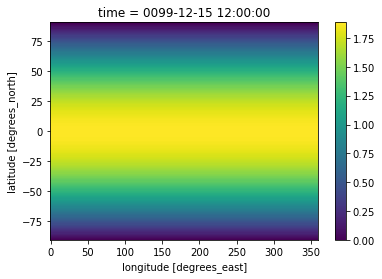

In [34]:
model = "CESM2"
cesm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
imem = list(cesm4x.variants)[0]
thisModelArea = getModelAreacella(model)
#dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
thisModelArea.areacella.plot()

In [35]:
list(ts4x_models)[0]

'BCC-CSM2-MR'

BCC-CSM2-MR: Area from cos lat


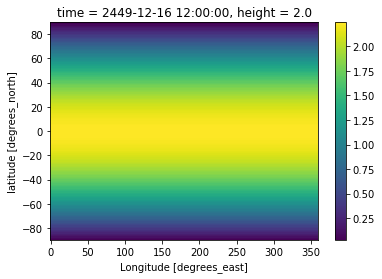

In [36]:
model=list(ts4x_models)[0]
cnrm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
imem = list(cnrm4x.variants)[0]
thisModelArea = getModelAreacella(model)
#dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
thisModelArea.areacella.plot()

### Use our tools to get the data and calculate ECS

In [37]:
ECS_models = ts4x_models

In [38]:
ts4x_models

{'BCC-CSM2-MR': <__main__.ModelExpVar at 0x7f04be937438>,
 'BCC-ESM1': <__main__.ModelExpVar at 0x7f04be937550>,
 'CAMS-CSM1-0': <__main__.ModelExpVar at 0x7f04be937208>,
 'CESM2-WACCM': <__main__.ModelExpVar at 0x7f04be93e908>,
 'CESM2': <__main__.ModelExpVar at 0x7f04be937128>,
 'CNRM-CM6-1': <__main__.ModelExpVar at 0x7f04be937278>,
 'CNRM-ESM2-1': <__main__.ModelExpVar at 0x7f04be93ec88>,
 'CanESM5': <__main__.ModelExpVar at 0x7f04be9370b8>,
 'E3SM-1-0': <__main__.ModelExpVar at 0x7f04be9375c0>,
 'EC-Earth3-Veg': <__main__.ModelExpVar at 0x7f04be937198>,
 'GISS-E2-1-G': <__main__.ModelExpVar at 0x7f05fab140b8>,
 'GISS-E2-1-H': <__main__.ModelExpVar at 0x7f05fab142e8>,
 'HadGEM3-GC31-LL': <__main__.ModelExpVar at 0x7f05fab143c8>,
 'IPSL-CM6A-LR': <__main__.ModelExpVar at 0x7f05fab14198>,
 'MIROC6': <__main__.ModelExpVar at 0x7f05fab14128>,
 'MRI-ESM2-0': <__main__.ModelExpVar at 0x7f05fab14908>,
 'SAM0-UNICON': <__main__.ModelExpVar at 0x7f05fab14438>,
 'UKESM1-0-LL': <__main__.Mode

In [39]:
ECS={}
for model in list(ECS_models):
    print(model)
    allECS = []
    for mem in list(ECS_models[model].variants):
        print(mem)

BCC-CSM2-MR
r1i1p1f1
BCC-ESM1
r1i1p1f1
CAMS-CSM1-0
r1i1p1f1
r2i1p1f1
CESM2-WACCM
r1i1p1f1
CESM2
r1i1p1f1
CNRM-CM6-1
r1i1p1f2
CNRM-ESM2-1
r1i1p1f2
r2i1p1f2
r3i1p1f2
CanESM5
r1i1p1f1
r1i1p2f1
E3SM-1-0
r1i1p1f1
EC-Earth3-Veg
r1i1p1f1
GISS-E2-1-G
r102i1p1f1
r1i1p1f1
GISS-E2-1-H
r1i1p1f1
HadGEM3-GC31-LL
r1i1p1f3
IPSL-CM6A-LR
r1i1p1f1
MIROC6
r1i1p1f1
MRI-ESM2-0
r10i1p1f1
r13i1p1f1
r1i1p1f1
r4i1p1f1
r7i1p1f1
SAM0-UNICON
r1i1p1f1
UKESM1-0-LL
r1i1p1f2
GFDL-CM4
r1i1p1f1
NESM3
r1i1p1f1
MIROC-ES2L
r1i1p1f2
NorESM2-LM
r1i1p1f1


In [40]:
ECS={}
for model in list(ECS_models):
    print(model)
    allECS = []
    for mem in list(ECS_models[model].variants):
        print(mem)
        thisECS,F = calcECSts(model,mem)
        (model,mem)
        allECS.append(thisECS)
        print(thisECS/2)
    ECS[model] = np.average(allECS)

BCC-CSM2-MR
r1i1p1f1
BCC-CSM2-MR: Area from cos lat
/project/cmip6/piControl/Amon/ts/BCC-CSM2-MR/r1i1p1f1/gn/ts_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
ts
/project/cmip6/piControl/Amon/rsdt/BCC-CSM2-MR/r1i1p1f1/gn/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
rsdt
/project/cmip6/piControl/Amon/rsut/BCC-CSM2-MR/r1i1p1f1/gn/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
rsut
/project/cmip6/piControl/Amon/rlut/BCC-CSM2-MR/r1i1p1f1/gn/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
rlut
2.9312830532206493
BCC-ESM1
r1i1p1f1
BCC-ESM1: Area from cos lat
/project/cmip6/piControl/Amon/ts/BCC-ESM1/r1i1p1f1/gn/ts_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
ts
/project/cmip6/piControl/Amon/rsdt/BCC-ESM1/r1i1p1f1/gn/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
rsdt
/project/cmip6/piControl/Amon/rsut/BCC-ESM1/r1i1p1f1/gn/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
rsut
/project/cmip6/piControl/Amon/rlut/BCC

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
/project/cmip6/piControl/Amon/ts/IPSL-CM6A-LR/r1i1p1f1/gr/ts_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

ts
/project/cmip6/piControl/Amon/ts/IPSL-CM6A-LR/r1i2p1f1/gr/ts_Amon_IPSL-CM6A-LR_piControl_r1i2p1f1_gr_185001-209812.nc
ts


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
/project/cmip6/piControl/Amon/rsdt/IPSL-CM6A-LR/r1i1p1f1/gr/rsdt_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

rsdt
/project/cmip6/piControl/Amon/rsdt/IPSL-CM6A-LR/r1i2p1f1/gr/rsdt_Amon_IPSL-CM6A-LR_piControl_r1i2p1f1_gr_185001-209812.nc
rsdt


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
/project/cmip6/piControl/Amon/rsut/IPSL-CM6A-LR/r1i1p1f1/gr/rsut_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

rsut
/project/cmip6/piControl/Amon/rsut/IPSL-CM6A-LR/r1i2p1f1/gr/rsut_Amon_IPSL-CM6A-LR_piControl_r1i2p1f1_gr_185001-209812.nc
rsut


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
/project/cmip6/piControl/Amon/rlut/IPSL-CM6A-LR/r1i1p1f1/gr/rlut_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc


OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 415, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/project/ccr/apgrass/miniconda3/envs/cmip6/lib/python3.7/site-packages/pandas/core/arrays/timedelt

rlut
/project/cmip6/piControl/Amon/rlut/IPSL-CM6A-LR/r1i2p1f1/gr/rlut_Amon_IPSL-CM6A-LR_piControl_r1i2p1f1_gr_185001-209812.nc
rlut
4.483081612984019
MIROC6
r1i1p1f1
MIROC6: Area from cos lat
/project/cmip6/piControl/Amon/ts/MIROC6/r1i1p1f1/gn/ts_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-329912.nc
ts
/project/cmip6/piControl/Amon/rsdt/MIROC6/r1i1p1f1/gn/rsdt_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-329912.nc
rsdt
/project/cmip6/piControl/Amon/rsut/MIROC6/r1i1p1f1/gn/rsut_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-329912.nc
rsut
/project/cmip6/piControl/Amon/rlut/MIROC6/r1i1p1f1/gn/rlut_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-329912.nc
rlut
2.5378744943208553
MRI-ESM2-0
r10i1p1f1
MRI-ESM2-0: Area from cos lat
/project/cmip6/piControl/Amon/ts/MRI-ESM2-0/r1i1p1f1/gn/ts_Amon_MRI-ESM2-0_piControl_r1i1p1f1_gn_185001-255012.nc
ts
/project/cmip6/piControl/Amon/rsdt/MRI-ESM2-0/r1i1p1f1/gn/rsdt_Amon_MRI-ESM2-0_piControl_r1i1p1f1_gn_185001-255012.nc
rsdt
/project/cmip6/piControl/Amon/rsut/MRI-ESM2-

### Make an ordered list of the ECS values, plot ECS/2 in a bar plot (to get ECS for CO2-doubling, which is more familiar), and save the data.

In [41]:
orderedECS = sorted(ECS.items(), key=lambda x: x[1])
oECS = {}
for pair in orderedECS:
    #print(pair[0])
    #print(pair[1])
    oECS[pair[0]]=pair[1]
    
print(oECS)
oECS = { pair[0]:pair[1] for pair in orderedECS }
print(oECS)    

{'CAMS-CSM1-0': 4.443374472087797, 'MIROC6': 5.075748988641711, 'GISS-E2-1-G': 5.132494040046886, 'NorESM2-LM': 5.1403509831970595, 'MIROC-ES2L': 5.350901350029898, 'BCC-CSM2-MR': 5.862566106441299, 'GISS-E2-1-H': 5.927573585413899, 'MRI-ESM2-0': 6.603966679726284, 'BCC-ESM1': 6.6505168712144815, 'SAM0-UNICON': 7.436034561120744, 'GFDL-CM4': 7.6702283876118775, 'EC-Earth3-Veg': 8.06409323996796, 'NESM3': 8.923383463621757, 'IPSL-CM6A-LR': 8.966163225968039, 'CESM2-WACCM': 9.206069182694343, 'CNRM-ESM2-1': 9.308267931166114, 'CNRM-CM6-1': 9.589815082354109, 'CESM2': 10.237067067918854, 'UKESM1-0-LL': 10.533042034804915, 'E3SM-1-0': 10.578804602123864, 'HadGEM3-GC31-LL': 10.814856440151704, 'CanESM5': 11.182602215423397}
{'CAMS-CSM1-0': 4.443374472087797, 'MIROC6': 5.075748988641711, 'GISS-E2-1-G': 5.132494040046886, 'NorESM2-LM': 5.1403509831970595, 'MIROC-ES2L': 5.350901350029898, 'BCC-CSM2-MR': 5.862566106441299, 'GISS-E2-1-H': 5.927573585413899, 'MRI-ESM2-0': 6.603966679726284, 'BCC-

Text(0.5, 1.0, 'ECS for CMIP6 models (16 Octoboer 2019)')

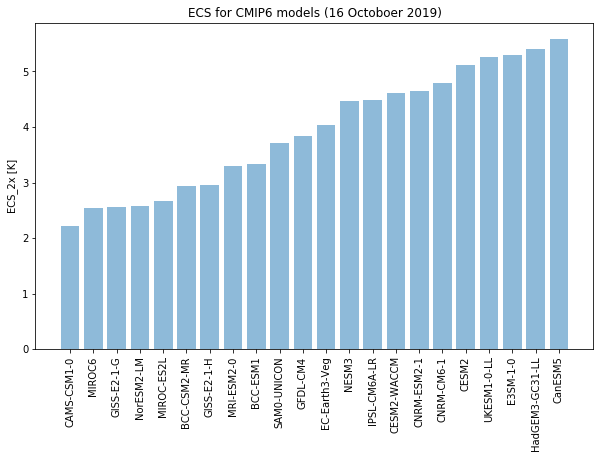

In [42]:
ecs2x = []
for val in oECS.values():
    ecs2x.append(val/2)


objects = oECS.keys()
y_pos = np.arange(len(objects))
performance = ecs2x


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=90)
plt.ylabel('ECS_2x [K]')
plt.title('ECS for CMIP6 models (16 Octoboer 2019)')

In [43]:
fig.savefig('cmip6-ecs-16102019-cgd.pdf')

In [44]:
w = csv.writer(open("cmip6-ecs-16102019-cgd.csv", "w"))
for key, val in oECS.items():
    w.writerow([key, val])


In [45]:
oECS

{'CAMS-CSM1-0': 4.443374472087797,
 'MIROC6': 5.075748988641711,
 'GISS-E2-1-G': 5.132494040046886,
 'NorESM2-LM': 5.1403509831970595,
 'MIROC-ES2L': 5.350901350029898,
 'BCC-CSM2-MR': 5.862566106441299,
 'GISS-E2-1-H': 5.927573585413899,
 'MRI-ESM2-0': 6.603966679726284,
 'BCC-ESM1': 6.6505168712144815,
 'SAM0-UNICON': 7.436034561120744,
 'GFDL-CM4': 7.6702283876118775,
 'EC-Earth3-Veg': 8.06409323996796,
 'NESM3': 8.923383463621757,
 'IPSL-CM6A-LR': 8.966163225968039,
 'CESM2-WACCM': 9.206069182694343,
 'CNRM-ESM2-1': 9.308267931166114,
 'CNRM-CM6-1': 9.589815082354109,
 'CESM2': 10.237067067918854,
 'UKESM1-0-LL': 10.533042034804915,
 'E3SM-1-0': 10.578804602123864,
 'HadGEM3-GC31-LL': 10.814856440151704,
 'CanESM5': 11.182602215423397}

In [46]:
w = csv.writer(open("cmip6-ecs-16102019-cgd.csv", "w"))
for key, val in oECS.items():
    w.writerow([key, val])
